Selecting the Most Important Features
===

<div class="alert alert-block alert-info">
Author: Nathan A. Mahynski

Date: 2023/08/31

Description: Examples of different ways to select important features for modeling.
</div>

In [4]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [5]:
import sklearn
import numpy as np
import pandas as pd

In [6]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
pychemauth: 0.0.0b3
numpy     : 1.24.4
sklearn   : 1.3.0
json      : 2.0.9
matplotlib: 3.7.2
pandas    : 2.0.3



WE can select features to include based on model performance.  This works for both classification an regression problems since the depends ont he model (e.g. R^2 for regression or accuracy for classification)

<h3>Load the data</h3

Load some example data downloaded from Kaggle [here]()https://www.kaggle.com/datasets/mathchi/hitters-baseball-data?select=Hitters.csv

In [25]:
# df = pd.read_csv('../data/Hitters.csv')

# # Let's do a little clean up and only select the numerical columns.
# df = df.select_dtypes(include=np.number).dropna()

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     df.iloc[:,:-1].values,
#     df['Salary'].values, # Let's try to predict the salary based on the other numerical features.
#     shuffle=True,
#     random_state=42,
#     test_size=0.2
# )

# from pychemauth.preprocessing.scaling import CorrectedScaler

# scaler = CorrectedScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [108]:
# from sklearn.datasets import load_diabetes as load_data
# X, y = load_data(return_X_y=True, as_frame=True)

from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, 
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y
)

from pychemauth.preprocessing.scaling import CorrectedScaler

scaler = CorrectedScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LASSO
--

In [100]:
# Basic L1 norm to remove features from a linear model

In [114]:
from sklearn.linear_model import Lasso

In [115]:
alpha_values = np.logspace(-5, 1, 50)
test_score, train_score = [], []

for alpha in alpha_values:
    model = Lasso(
        alpha=alpha,
        fit_intercept=True, 
        copy_X=True, 
        max_iter=10000, 
        tol=0.0001, 
        random_state=42, 
        selection='cyclic'
    )
    
    _ = model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

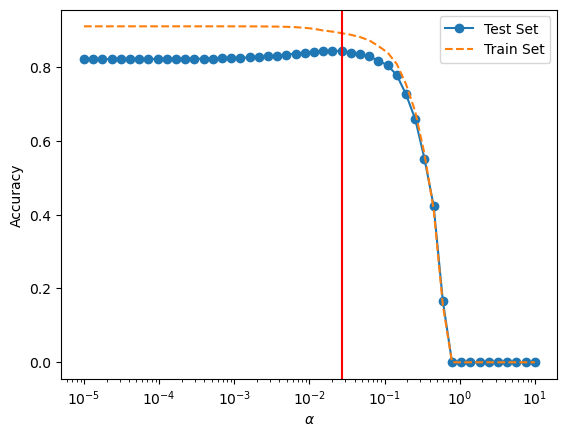

In [116]:
plt.plot(alpha_values, test_score, 'o-', label='Test Set')
plt.plot(alpha_values, train_score, '--', label='Train Set')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel(r'$\alpha$')
plt.legend(loc='best')

best_alpha = alpha_values[np.argmax(test_score)]
_ = plt.axvline(best_alpha, color='red')

In [117]:
model = Lasso(
    alpha=best_alpha,
    fit_intercept=True, 
    copy_X=True, 
    max_iter=10000, 
    tol=0.0001, 
    random_state=42, 
    selection='cyclic'
)
    
_ = model.fit(X_train, y_train)

In [118]:
model.coef_

array([-0.02728331,  0.00235296, -0.        ,  0.09899149, -0.        ,
        0.        , -0.3412534 , -0.        ,  0.        ,  0.10316551,
       -0.05387134, -0.13533276, -0.20734277])

In [119]:
X.columns[np.abs(model.coef_) == 0]

Index(['ash', 'magnesium', 'total_phenols', 'nonflavanoid_phenols',
       'proanthocyanins'],
      dtype='object')

In [120]:
X.columns[np.abs(model.coef_) > 0]

Index(['alcohol', 'malic_acid', 'alcalinity_of_ash', 'flavanoids',
       'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

Using Feature Importances
---

In [ ]:
# selectFromModel - can be any model
# Basic intro with use of feature importances using RF as model for importances

BorutaSHAP
---

In [ ]:
# All RELEVNAT feature selection method which keeps all which MIGHT be useful
# SHAP determines feature importances now not a RF

Recursive Feature Elimination
---

In [3]:
# also uses feature importances

Sequential Feature Selection
---

In [2]:
# Forward and backward
# based on performance not feature importances

In [124]:
from sklearn.feature_selection import SequentialFeatureSelector
from pychemauth.classifier.simca import SIMCA_Authenticator

In [ ]:
compliant = SIMCA_Authenticator(
    n_components=3,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=1, # Let's model class 1
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

In [176]:
sfs = SequentialFeatureSelector(
    compliant, 
    n_features_to_select='auto', 
    tol=0.1, 
    direction='backward', 
    scoring=None, # Use estimator's score method by default - for a compliant DD-SIMCA authenticator, this is TEFF
    cv=sklearn.model_selection.KFold(n_splits=5, random_state=0, shuffle=True), 
    n_jobs=None
)

In [177]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                          direction='backward',
                          estimator=SIMCA_Authenticator(n_components=3,
                                                        target_class=1,
                                                        use='compliant'),
                          tol=0.1)

In [178]:
sfs.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12'], dtype=object)

In [179]:
X.columns[~sfs.support_]

Index(['magnesium'], dtype='object')

In [ ]:
# forward has problems with small number of components - should add feature to SIMCA that suppresses certain errros

Using Heirarchical Clustering
---

Letting the Data Decide
---

In [ ]:
# pipeline with different feature selectors inside a gridsearchCV as grid_params